In [1]:
import os
import pandas as pd
from datetime import datetime as dt
import pickle
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

In [2]:
root = os.path.abspath(os.path.join(os.getcwd(),'..'))

In [3]:
reservoirs = ['harangi','kabini','krishnaraja_sagar','bhadra','lower_bhawani','hemavathy']

In [25]:
dfs = {r:pd.read_csv(os.path.join(root,'wave2web_data',f'{r}-final_round.csv')).set_index('date') for r in reservoirs}

In [26]:
# make a dt index
for kk in dfs.keys():
    dfs[kk].index = pd.to_datetime(dfs[kk].index)

In [27]:
for kk in dfs.keys():
    # fill missing dates with nan
    dfs[kk] = pd.merge(
        pd.DataFrame(index=pd.date_range(dfs[kk].index.min(), dfs[kk].index.max(), freq='1D')),
        dfs[kk], 
        how='left',
        left_index=True, 
        right_index=True
    )

In [28]:
# drop corrupt tape data
for kk in dfs.keys():
    dfs[kk] = dfs[kk].loc[((dfs[kk].index<dt(2016,11,1)) | (dfs[kk].index>=dt(2017,11,1))),:]

In [29]:
dfs['krishnaraja_sagar']

,volume_bcm,tp_0,tp_1,tp_2,tp_3,tp_4,tp_5,tp_6,tp_7,tp_8,...,t2m_5,t2m_6,t2m_7,t2m_8,t2m_9,t2m_10,t2m_11,t2m_12,t2m_13,t2m_14
2010-01-01,1.088,6.761192,15.155061,15.193449,15.199100,15.196366,15.362895,15.388023,15.395256,15.539435,...,294.113185,293.896043,294.224000,295.169267,294.593875,296.043687,296.855186,295.962557,295.862606,296.317669
2010-01-02,1.094,0.054987,0.081419,0.083375,0.082551,0.287213,0.410912,0.660227,12.452221,51.569395,...,294.186796,295.681919,293.733370,294.913645,294.595438,294.665314,295.244730,296.069031,295.893279,296.043649
2010-01-03,1.099,0.000000,0.000000,0.027047,0.138493,0.300284,0.863664,3.899491,14.636822,24.326131,...,295.732890,296.038631,296.064235,295.877771,294.972064,294.621084,295.017658,296.505428,296.649512,296.449103
2010-01-04,1.102,0.000000,0.062458,0.525168,0.681287,0.882553,0.882826,0.931023,1.089093,20.241449,...,295.627973,296.079014,296.678018,295.282201,295.999646,296.266234,296.726590,296.752669,295.196792,295.480459
2010-01-05,1.104,0.000000,0.024409,1.113137,1.202568,1.805830,16.787445,29.909433,33.030618,43.889752,...,295.577670,296.384672,296.617068,295.807070,295.683263,295.456163,296.906702,296.536088,296.466812,296.816892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-06,NaN,48.579528,167.023449,227.582733,279.151382,306.933133,339.393688,388.146584,449.008206,491.502557,...,294.551236,294.696228,294.561403,294.987968,295.043554,295.262787,295.322998,295.195989,295.621988,295.280004
2021-09-07,0.955,25.491809,92.248394,134.681493,151.948686,171.236614,211.611670,260.334295,300.418478,334.643542,...,294.611943,294.625204,294.898998,295.030973,295.020477,295.153154,295.150459,295.432485,295.683175,295.333329
2021-09-08,0.963,28.076460,73.374395,88.619113,117.515389,176.970313,237.974199,294.915379,337.075761,360.464259,...,294.745345,294.882667,295.149268,295.206998,295.292865,295.652318,295.502699,295.427120,295.394229,295.206216
2021-09-09,NaN,11.431100,27.444031,52.741503,123.078935,198.871393,257.803463,302.694266,327.332409,344.965500,...,294.976518,295.168405,295.117019,294.924492,295.456412,295.196203,295.338138,294.798102,295.132098,295.425089


In [30]:
# drop the max data
for kk in dfs.keys():
    most_recent_valid = dfs[kk].loc[~dfs[kk].isna().any(axis=1)].index.max()
    
    dfs[kk] = dfs[kk].loc[dfs[kk].index<=most_recent_valid,:]

In [31]:
# interp nan
for kk in dfs.keys():
    dfs[kk] = dfs[kk].interpolate(limit_direction='both',limit_area='inside',axis=0)

In [32]:
# z-score data
records = {}
for kk in dfs.keys():
    records[kk] = {
        'mean':dfs[kk].mean().to_dict(),
        'std':dfs[kk].std().to_dict(),
    }
    
    dfs[kk] = (dfs[kk] - dfs[kk].mean())/dfs[kk].std()/3
    
    pickle.dump(records, open(os.path.join(root,'wave2web_data','3zscore_params.pkl'),'wb'))


In [33]:
### trn-test-val split

In [34]:
baseline_yrmnths = dfs['kabini'].index.astype(str).str[0:7].unique()[2:].tolist()

In [43]:
chosen_months = []
baseline_yrmnths = dfs['kabini'].index.astype(str).str[0:7].unique()[2:].tolist()
# need 3 months ahead for training
baseline_yrmnths = [el for el in baseline_yrmnths if el not in ['2021-06','2021-07','2021-08','2021-09','2016-08','2016-09','2016-10','2017-11','2017-12']]
deploy_yrmnths = baseline_yrmnths + ['2021-06','2021-07','2021-08','2021-09']
# want a 3 month window...
available_yrmnths = [el for el in baseline_yrmnths if el not in ['2021-04','2021-05','2016-06','2016-07']]
yrmnth_idxs = range(len(available_yrmnths))
# select 9+9 start months randomly
for ii in range(18):
    chosen_month = np.random.choice(yrmnth_idxs)
    chosen_months.append(chosen_month)
    yrmnth_idxs = [m for m in yrmnth_idxs if m not in range(chosen_month, chosen_month+3)]
    print(chosen_month, len(yrmnth_idxs))

80 111
24 108
58 105
14 102
55 99
47 96
74 93
92 90
112 88
12 86
96 83
37 80
2 77
101 74
67 71
22 69
90 67
31 64


In [44]:
val_yrmnths = np.array(available_yrmnths)[chosen_months[0:9]]
test_yrmnths = np.array(available_yrmnths)[chosen_months[9:]]

In [45]:
val_yrmnths, test_yrmnths

(array(['2018-06', '2012-03', '2015-01', '2011-05', '2014-10', '2014-02',
        '2016-05', '2019-06', '2021-02'], dtype='<U7'),
 array(['2011-03', '2019-10', '2013-04', '2010-05', '2020-03', '2015-10',
        '2012-01', '2019-04', '2012-10'], dtype='<U7'))

In [46]:
for kk in dfs.keys():
    dfs[kk]['yrmnth'] = dfs[kk].index.astype(str).str[0:7]
    dfs[kk]['set'] = np.nan
    dfs[kk].loc[dfs[kk]['yrmnth'].isin(baseline_yrmnths),'set'] = 'trn'

    for yrmnth in val_yrmnths:
        year, month = yrmnth.split('-')
        sdt = dt(int(year), int(month),1)
        edt = sdt + relativedelta(months=3)
        dfs[kk].loc[((dfs[kk].index>=sdt) & (dfs[kk].index<edt)),'set'] = 'val'
        
    for yrmnth in test_yrmnths:
        year, month = yrmnth.split('-')
        sdt = dt(int(year), int(month),1)
        edt = sdt + relativedelta(months=3)
        dfs[kk].loc[((dfs[kk].index>=sdt) & (dfs[kk].index<edt)),'set'] = 'test'

In [47]:
for kk in dfs.keys():
    dfs[kk].loc[pd.isna(dfs[kk]['set']) & dfs[kk]['yrmnth'].isin(deploy_yrmnths),'set']='deploy'

In [48]:
for kk in dfs.keys():
    dfs[kk].to_csv(os.path.join(root,'wave2web_data',f'{kk}_3zscore.csv'))

In [49]:
dfs['kabini'].loc[(dfs['kabini'].index>=dt(2016,8,3)) & (dfs['kabini'].index<dt(2016,9,1)),:]

,volume_bcm,tp_0,tp_1,tp_2,tp_3,tp_4,tp_5,tp_6,tp_7,tp_8,...,t2m_7,t2m_8,t2m_9,t2m_10,t2m_11,t2m_12,t2m_13,t2m_14,yrmnth,set
2016-08-03,0.228737,0.008650,0.009798,0.052330,0.072839,0.048327,0.013856,-0.015285,-0.038384,-0.056533,...,-0.165575,-0.168064,-0.267064,-0.386068,-0.427931,-0.489391,-0.593530,-0.368573,2016-08,NaN
2016-08-04,0.228737,0.076975,0.168885,0.266237,0.206463,0.140917,0.082137,0.042963,0.014409,-0.011646,...,-0.159722,-0.108981,-0.322557,-0.450640,-0.480450,-0.574547,-0.464963,-0.435298,2016-08,NaN
2016-08-05,0.226289,0.064349,0.144880,0.172375,0.102542,0.045223,-0.000993,-0.033844,-0.054272,-0.072117,...,-0.200968,-0.154394,-0.373629,-0.474168,-0.594004,-0.527695,-0.490386,-0.334282,2016-08,NaN
2016-08-06,0.231185,0.153427,0.075544,0.002947,-0.039961,-0.079747,-0.104352,-0.087613,-0.077870,-0.081625,...,-0.068724,-0.336883,-0.388114,-0.440649,-0.482033,-0.474512,-0.397139,-0.356941,2016-08,NaN
2016-08-07,0.245875,-0.074907,-0.122881,-0.150922,-0.175341,-0.187342,-0.196933,-0.203350,-0.206511,-0.197066,...,-0.140932,-0.300452,-0.465763,-0.475062,-0.546693,-0.475700,-0.326599,-0.265100,2016-08,NaN
2016-08-08,0.250771,-0.092055,-0.113933,-0.112903,-0.114799,-0.125388,-0.135884,-0.141820,-0.139203,-0.132076,...,-0.239418,-0.338049,-0.443237,-0.402952,-0.240186,-0.240459,-0.170733,-0.145055,2016-08,NaN
2016-08-09,0.255668,-0.119969,-0.132525,-0.127263,-0.128463,-0.140095,-0.150660,-0.148757,-0.142349,-0.128761,...,-0.313740,-0.408752,-0.366197,-0.303718,-0.149004,-0.140485,-0.237810,-0.260913,2016-08,NaN
2016-08-10,0.260564,-0.157679,-0.117928,-0.108594,-0.114264,-0.110785,-0.117694,-0.110551,-0.095499,-0.086906,...,-0.390210,-0.332397,-0.260032,-0.353908,-0.322631,-0.192742,-0.305168,-0.339367,2016-08,NaN
2016-08-11,0.260564,-0.139066,-0.157876,-0.126723,-0.095739,-0.102390,-0.123153,-0.136510,-0.135577,-0.132246,...,-0.255344,-0.238595,-0.312976,-0.212484,-0.212385,-0.283234,-0.295692,-0.433183,2016-08,NaN
2016-08-12,0.255668,0.035816,-0.025756,-0.029188,-0.013274,0.007013,-0.000974,-0.013166,-0.031260,-0.049892,...,-0.174800,-0.117097,-0.107181,-0.084709,-0.209155,-0.247922,-0.404902,-0.463434,2016-08,NaN


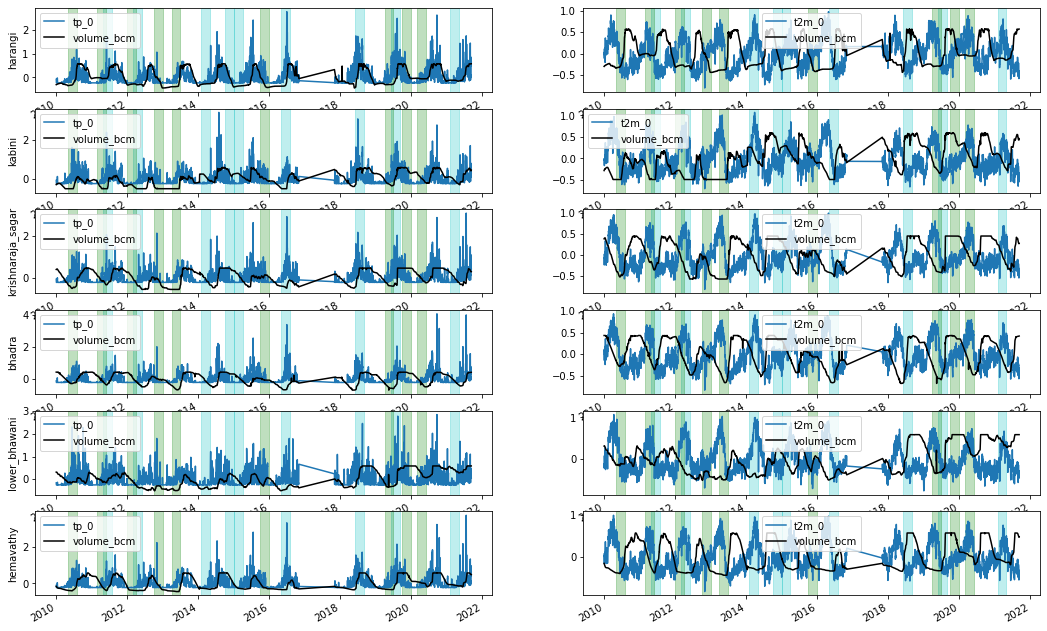

In [50]:
fig, axs = plt.subplots(6,2, figsize=(18,12))
for ii_k, (kk, df) in enumerate(dfs.items()):
    df[['tp_0']].plot(ax=axs[ii_k][0])
    df[['volume_bcm']].plot(ax=axs[ii_k][0], secondary_y='PRESENT_STORAGE_TMC', color='k')
    df[['t2m_0']].plot(ax=axs[ii_k][1])
    df[['volume_bcm']].plot(ax=axs[ii_k][1], secondary_y='PRESENT_STORAGE_TMC', color='k')
    axs[ii_k][0].set_ylabel(kk)
    
    for ii in range(2):
        for yrmnth in val_yrmnths:
            year, month = yrmnth.split('-')
            sdt = dt(int(year), int(month),1)
            edt = sdt + relativedelta(months=3)
            axs[ii_k][ii].axvspan(sdt, edt, color='c', alpha=0.25)

        for yrmnth in test_yrmnths:
            year, month = yrmnth.split('-')
            sdt = dt(int(year), int(month),1)
            edt = sdt + relativedelta(months=3)
            axs[ii_k][ii].axvspan(sdt, edt, color='g', alpha=0.25)
plt.show()

In [181]:
dfs['krishnaraja_sagar']['set']=='trn'

2010-01-01    False
2010-01-02    False
2010-01-03    False
2010-01-04    False
2010-01-05    False
              ...  
2021-09-04    False
2021-09-05    False
2021-09-06    False
2021-09-07    False
2021-09-08    False
Name: set, Length: 3943, dtype: bool

In [51]:
import pickle

In [53]:

df = pickle.load(open(os.path.join(root,'test.pkl'),'rb'))

In [61]:
dfs['kabini']

,volume_bcm,tp_0,tp_1,tp_2,tp_3,tp_4,tp_5,tp_6,tp_7,tp_8,...,t2m_7,t2m_8,t2m_9,t2m_10,t2m_11,t2m_12,t2m_13,t2m_14,yrmnth,set
2010-01-01,-0.285396,-0.068856,-0.125995,-0.177733,-0.205791,-0.222993,-0.233381,-0.243278,-0.251418,-0.258326,...,-0.184370,-0.062128,-0.034188,0.131765,0.398899,0.133470,0.002556,0.212675,2010-01,NaN
2010-01-02,-0.275603,-0.231067,-0.236290,-0.249916,-0.259023,-0.262800,-0.268675,-0.273121,-0.240585,-0.170352,...,-0.269289,-0.196454,-0.203962,-0.144673,-0.129240,0.040059,0.008671,0.038126,2010-01,NaN
2010-01-03,-0.265810,-0.231461,-0.236499,-0.249747,-0.259731,-0.262865,-0.268163,-0.268533,-0.248250,-0.236040,...,0.021652,-0.059561,-0.220994,-0.273879,-0.087279,0.187669,0.202288,0.156324,2010-01,NaN
2010-01-04,-0.265810,-0.231461,-0.236478,-0.244722,-0.251304,-0.256376,-0.263608,-0.269273,-0.273569,-0.249445,...,0.118258,-0.152801,0.124906,0.141378,0.293819,0.246030,-0.064278,0.029328,2010-01,NaN
2010-01-05,-0.260913,-0.231461,-0.236499,-0.241327,-0.253121,-0.260798,-0.231521,-0.207519,-0.214034,-0.206340,...,0.104755,0.010066,0.051627,0.025682,0.347839,0.112806,0.192414,0.279452,2010-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-04,0.429494,0.344904,0.284681,0.548703,0.555488,0.525011,0.487159,0.422876,0.380603,0.350327,...,-0.212135,-0.171725,-0.260087,-0.249897,-0.183328,-0.139985,-0.148636,-0.096074,2021-09,deploy
2021-09-05,0.429494,0.469293,0.966062,0.825386,0.771262,0.700526,0.593347,0.515644,0.460003,0.428486,...,-0.207148,-0.224396,-0.234554,-0.251277,-0.208208,-0.102558,-0.087215,-0.134288,2021-09,deploy
2021-09-06,0.429494,0.806717,1.087130,0.910588,0.788624,0.639920,0.538898,0.495669,0.483719,0.455240,...,-0.266780,-0.211355,-0.182572,-0.123328,-0.093632,-0.068967,-0.027120,-0.120753,2021-09,deploy
2021-09-07,0.429494,0.420153,0.491261,0.382504,0.256324,0.185885,0.188222,0.196647,0.194400,0.189713,...,-0.229651,-0.182315,-0.134760,-0.118543,-0.116140,-0.064851,-0.012990,-0.133313,2021-09,deploy


In [68]:
df = df.set_index(['level_0','prediction_dt']).drop(columns='level_1').unstack('level_0')

In [69]:
df.columns = df.columns.droplevel()

In [70]:
merge_df = pd.merge(
    df,
    dfs['kabini'][['volume_bcm']],
    how='left',
    left_index=True,
    right_index=True
)


In [78]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots()

In [84]:
merge_df[['volume_bcm','1 days']].isna().any(axis=1)

,volume_bcm,1 days
2010-03-02,False,False
2010-03-03,False,False
2010-03-04,False,False
2010-03-05,False,False
2010-03-06,False,False
...,...,...
2021-12-03,True,True
2021-12-04,True,True
2021-12-05,True,True
2021-12-06,True,True


<AxesSubplot:>

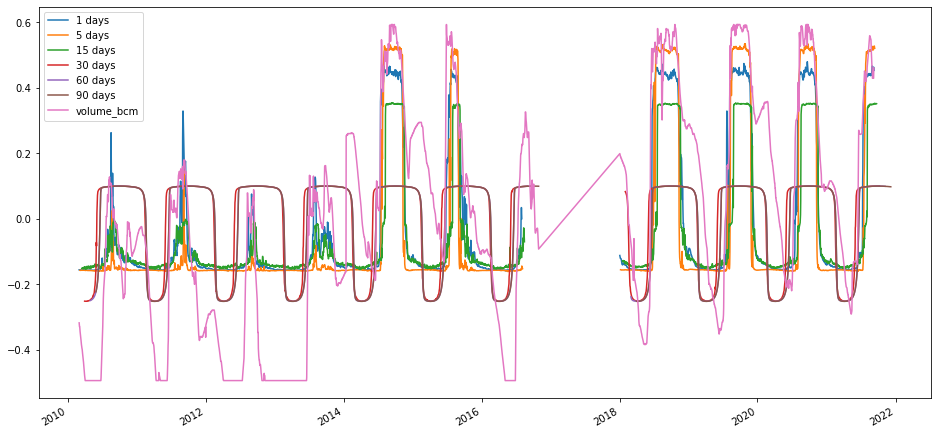

In [79]:
merge_df.plot(figsize=(16,8))

In [91]:
import glob, json

In [89]:
results_jsons = glob.glob(os.path.abspath(os.path.join(os.getcwd(),'..','w2w_results','*.json')))

In [93]:
data = {}
for f in results_jsons:
    kk = '_'.join(os.path.split(f)[-1].split('_')[:-1])
    print (kk)
    data[kk] = json.load(open(f,'r'))

lower_bhawani
bhadra
krishnaraja_sagar
hemavathy
kabini
harangi


In [97]:
df = pd.DataFrame(data).T

<AxesSubplot:>

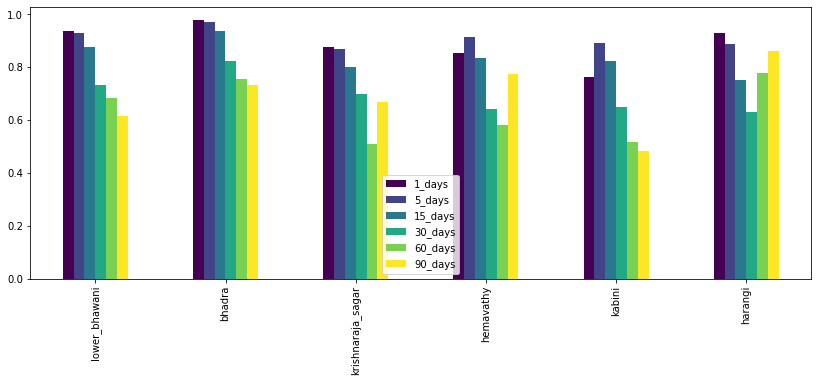

In [106]:
df.plot.bar(cmap='viridis', figsize=(14,5))